# Crevasse Detection Notebook to detect crevasses, supraglacial streams/lakes on Greenland from S1 Imagery

### Import packages

In [1]:
# Manually add environment's bin dir to the path inside notebook to run tensorboard
import os
PATH = os.getenv('PATH')
%env PATH=/home/theghub/naureenk/.conda/envs/crev/bin:$PATH
    
# Magic command to load tensorboard extension
%load_ext tensorboard

# Magic command with tensorboard log directory
#%tensorboard --logdir augment_nullnorm_epoch15_0_2_dropout_3layer

# Mute TF 2.12 Bug Warnings (Needs to be Before importing tensorflow)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# dataloader module for TF input pipeline
# from dataloader import DataLoader

import sys

# Appending the U-net package folder
sys.path.append("./src/")
import unet
from unet import crevasse_data

# Import relevant modules from TF
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses, metrics
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
#keras.backend.set_image_data_format('channels_last')
import PIL
from PIL import ImageOps

env: PATH=/home/theghub/naureenk/.conda/envs/crev/bin:/apps/jupyterlab70/r2/bin:/apps/share64/debian10/anaconda/anaconda-7/bin:/bin:/usr/bin:/usr/bin/X11:/sbin:/usr/sbin


### Import Images and Labels to make tf datasets using dataloader class from DataLoader.py

In [2]:
IMAGE_DIR_PATH = "./gris/Images/"
MASK_DIR_PATH = "./gris/Labels/"
training_image_data = "./gris/Images/Train/"
valid_image_data = "./gris/Images/Valid/"
test_image_data = "./gris/Images/Test/"
training_mask_data = "./gris/Labels/Train/"
valid_mask_data = "./gris/Labels/Valid/"
test_mask_data = "./gris/Labels/Test/"

IMAGE_SIZE = (1024,1024)
BATCH_SIZE = 1

# create list of PATHS
## Train
train_image_paths = [os.path.join(training_image_data, x) for x in os.listdir(training_image_data) if x.endswith('.png')]
train_mask_paths = [os.path.join(training_mask_data, x) for x in os.listdir(training_mask_data) if x.endswith('.png')]
## Valid
valid_image_paths = [os.path.join(valid_image_data, x) for x in os.listdir(valid_image_data) if x.endswith('.png')]
valid_mask_paths = [os.path.join(valid_mask_data, x) for x in os.listdir(valid_mask_data) if x.endswith('.png')]
## Test
test_image_paths = [os.path.join(test_image_data, x) for x in os.listdir(test_image_data) if x.endswith('.png')]
test_mask_paths = [os.path.join(test_mask_data, x) for x in os.listdir(test_mask_data) if x.endswith('.png')]

# Where train_image_paths[0] = './gris/Images/Train/image_0.png' 
# And train_mask_paths[0] = './gris/Labels/Train/mask_0.png'


## TF TRAIN DATASET
# Initialize the dataloader object
train_dataset = DataLoader(image_paths=train_image_paths,
                           mask_paths=train_mask_paths,
                           image_size=IMAGE_SIZE,
                           crop_percent=None,
                           channels=(1, 1),
                           augment=True,
                           compose=False,
                           seed=2)

# Parse the images and masks, and return the data in batches, augmented optionally.
train_dataset = train_dataset.data_batch(batch_size=BATCH_SIZE,
                                         shuffle=True)


## TF VALID DATASET

# Initialize the dataloader object
valid_dataset = DataLoader(image_paths=valid_image_paths,
                           mask_paths=valid_mask_paths,
                           image_size=IMAGE_SIZE,
                           crop_percent=None,
                           channels=(1, 1),
                           augment=False,
                           compose=False,
                           seed=2)

# Parse the images and masks, and return the data in batches, augmented optionally.
valid_dataset = valid_dataset.data_batch(batch_size=BATCH_SIZE)


## TF TEST DATASET

# Initialize the dataloader object
test_dataset = DataLoader(image_paths=test_image_paths,
                          mask_paths=test_mask_paths,
                          image_size=IMAGE_SIZE,
                          crop_percent=None,
                          channels=(1, 1),
                          augment=False,
                          compose=False,
                          seed=2)

# Parse the images and masks, and return the data in batches, augmented optionally.
test_dataset = test_dataset.data_batch(batch_size=BATCH_SIZE)

### Image and Label folder paths

In [2]:
# Create list of image/label paths
IMAGE_DIR_PATH = "./gris/Images/"
MASK_DIR_PATH = "./gris/Labels with updated crevasse fields/"
#test_image_dir = "./gris/Images/Test/"
#test_mask_dir = "./gris/Images/Test/" 
img_size = (1024,1024)
batch_size = 1
input_img_paths = sorted([os.path.join(IMAGE_DIR_PATH, x) for x in os.listdir(IMAGE_DIR_PATH) if x.endswith('.png')])
target_img_paths = sorted([os.path.join(MASK_DIR_PATH, x) for x in os.listdir(MASK_DIR_PATH) if x.endswith('.png')])
print("Number of samples:", len(input_img_paths))
#test_img_paths = sorted([os.path.join(test_image_dir, x) for x in os.listdir(test_image_dir) if x.endswith('.png')])
#test_mask_paths = sorted([os.path.join(test_mask_dir, x) for x in os.listdir(test_mask_dir) if x.endswith('.png')])

Number of samples: 6


### CrevasseData class to parse data like a tensor

In [3]:
import numpy as np

# Class Crevasse Data to create the tuple to contain the dataset
class CrevasseData(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        # Placeholder for input images defining the dimensions
        # (batch size, image size, channels), dtype=?? (Needs to be compatible with corresponding image dimensions)
        # channels=(1,) for grayscale or (3,) for rgb and vice versa
        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = tf.cast(tf.image.resize(tf.image.decode_png((tf.io.read_file(path)), channels=1),self.img_size),tf.float32)/255.0
            #img = load_img(path, target_size=self.img_size, color_mode="grayscale") # doesnt work
            x[j] = img
        # Placeholder for input labels defining the dimensions
        # (batch size, image size, channels), dtype=?? (Needs to be compatible with corresponding label dimensions)
        # channels=(1,) for grayscale / (n,) for one-hot encoded n-channeled labels
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            # Expand dimensions to Make label shape (image_size, image_size, 1)
            y[j] = np.expand_dims(img,2)
        return x, y

### Use CrevasseData class to generate Train/Valid/Test Dataset

In [4]:
import random

# Split img paths into a training and a validation set
val_samples = 1

# Validation samples need to separate from training (maybe read them beforehand before shuffling all training images)
#  setdiff 
#random.Random(1337).shuffle(input_img_paths)
#random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]



# Instantiate data Sequences for each split
train_gen = CrevasseData(batch_size, img_size, train_input_img_paths, train_target_img_paths)

val_gen = CrevasseData(batch_size, img_size, val_input_img_paths, val_target_img_paths)

#test_gen = CrevasseData(batch_size, img_size, test_img_paths, test_mask_paths)

### Implementation of Segmentation Models Package using U-Net

In [5]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
# Appending the segmentation models package folder
sys.path.append("./segmentation_models/segmentations_models/")
import segmentation_models as sm

BACKBONE = 'resnet34'
#preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
#x_train, y_train, x_val, y_val = load_data(...)

# preprocess input
#x_train = preprocess_input(x_train)
#x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, classes=3, activation='softmax', input_shapes=(None, None, 1), encoder_weights=None)
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

Segmentation Models: using `tf.keras` framework.


In [6]:
# Early Stopping sets a epoch patience value to stop training if the monitored metric stops improving
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='sm_3class_unet_resnet34')]
# Fit the model with the training and/or validation data
# run for fewer epochs to prevent overfitting
model.fit(train_gen, validation_data=val_gen, batch_size=1, epochs=20, callbacks=callbacks)

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node 'model_1/bn_data/FusedBatchNormV3' defined at (most recent call last):
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_78911/702084820.py", line 6, in <module>
      model.fit(train_gen, validation_data=val_gen, batch_size=1, epochs=20, callbacks=callbacks)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 922, in call
      outputs = self._fused_batch_norm(
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 688, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/utils/control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/home/theghub/naureenk/.conda/envs/crev/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 662, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_1/bn_data/FusedBatchNormV3'
scale must have the same number of elements as the channels of x, got 3 and 1
	 [[{{node model_1/bn_data/FusedBatchNormV3}}]] [Op:__inference_train_function_19431]

## Build U-Net Model with n-classes, n-size inputs, n(3 and up)-layers, n(multiple of 16)-feature channels

### 4 Layered U-Net Model starting with 16 feature maps up to 128 feature maps

In [5]:
# Number of classes
num_classes = 3

# Input size depending on image size
inputs = tf.keras.layers.Input((1024, 1024, 1))

# Data augmentation
augmented_inputs = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                        tf.keras.layers.RandomRotation(0.25),tf.keras.layers.RandomContrast(0.2)])(inputs)

## Contraction path/Encoding/Desampling

# 1st layer with 16 feature channels:  double conv+ReLU+Maxpool
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(augmented_inputs)
# The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during 
# training time, which helps prevent overfitting. 
c1 = tf.keras.layers.Dropout(0.2)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
# batch normalization prevents overfitting compared to traditional unet
#b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(c1)
#r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

# 2nd layer with 32 feature channels:  double conv+ReLU+Maxpool
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.2)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
#b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(c2)
#r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

# 3rd layer with 64 feature channels:  double conv+ReLU+Maxpool
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.3)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
#b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(c3)
#r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)

# 4th layer with 128 feature channels:  double conv+ReLU+Maxpool
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.5)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
#b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(c4)
#r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)

# 5th layer with 256 feature channels:
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
#b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(c5)
#r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path/Decoding/Upsampling

# Transpose conv+concatenate features with the corresponding 4th layer features+ReLU
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
#u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

# Transpose conv+concatenate features with the corresponding 3rd layer features+ReLU 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
#u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

# Transpose conv+concatenate features with the corresponding 2nd layer features+ReLU 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
#u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)

# Transpose conv+concatenate features with the corresponding 1st layer features+ReLU
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
#u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

# Final 1*1 conv+softmax to calculate probabilities of each class; output dimension = (size, size, num_classes);
# i.e. probabilities = (0 + 0.9 + 0.1) = 1
outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(u9)

### 3 layered U-Net model starting with 16 feature maps up to 64 feature maps

In [5]:
# Number of classes
num_classes = 3

# Add data augmentation before model building

# Input size depending on image size
inputs = tf.keras.layers.Input((1024, 1024, 1))

# Data augmentation
augmented_inputs = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                        tf.keras.layers.RandomRotation(0.25)])(inputs)

## Contraction path/Encoding/Desampling

# 1st layer with 16 feature channels:  double conv+ReLU+Maxpool
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(augmented_inputs)
# The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during 
# training time, which helps prevent overfitting. 
c1 = tf.keras.layers.Dropout(0.3)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(c1)
# batch normalization prevents overfitting compared to traditional unet
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
#r1 = tf.keras.layers.ReLU()(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

# 2nd layer with 32 feature channels:  double conv+ReLU+Maxpool
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.3)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
#r2 = tf.keras.layers.ReLU()(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

# 3rd layer with 64 feature channels:  double conv+ReLU+Maxpool
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.4)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
#r3 = tf.keras.layers.ReLU()(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)

# 4th layer with 128 feature channels:
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(p3)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
#r4 = tf.keras.layers.ReLU()(c4)
c4 = tf.keras.layers.Dropout(0.4)(r4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(c4)

# Expansive path/Decoding/Upsampling

# Transpose conv+concatenate features with the corresponding 3rd layer features+ReLU
u5 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
u5 = tf.keras.layers.concatenate([u5, c3])
u5 = tf.keras.layers.BatchNormalization()(u5)
u5 = tf.keras.layers.ReLU()(u5)

# Transpose conv+concatenate features with the corresponding 2nd layer features+ReLU 
u6 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u5)
u6 = tf.keras.layers.concatenate([u6, c2])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

# Transpose conv+concatenate features with the corresponding 1st layer features+ReLU 
u7 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c1], axis=3)
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

# Final 1*1 conv+softmax to calculate probabilities of each class; output dimension = (size, size, num_classes);
# i.e. probabilities = (0 + 0.9 + 0.1) = 1
outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(u7)

### 2 layered U-Net model starting with 16 feature maps up to 32 feature maps

In [5]:
# Number of classes
num_classes = 3

# Add data augmentation before model building

# Input size depending on image size
inputs = tf.keras.layers.Input((1024, 1024, 1))

# Data augmentation
augmented_inputs = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                        tf.keras.layers.RandomRotation(0.25),tf.keras.layers.RandomContrast(0.05)])(inputs)

## Contraction path/Encoding/Desampling

# 1st layer with 16 feature channels:  double conv+ReLU+Maxpool
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='valid')(augmented_inputs)
# The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during 
# training time, which helps prevent overfitting. 
c1 = tf.keras.layers.Dropout(0.2)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='valid')(c1)
# batch normalization prevents overfitting compared to traditional unet
#b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(c1)
#r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

# 2nd layer with 32 feature channels:  double conv+ReLU+Maxpool
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='valid')(p1)
c2 = tf.keras.layers.Dropout(0.2)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='valid')(c2)
#b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(c2)
#r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

# 4th layer with 64 feature channels:
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='valid')(p2)
#b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(c3)
#r3 = tf.keras.layers.ReLU()(b3)
c3 = tf.keras.layers.Dropout(0.3)(r3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='valid')(c3)

# Expansive path/Decoding/Upsampling

# Transpose conv+concatenate features with the corresponding 3rd layer features+ReLU
u4 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='valid')(c3)
u4 = tf.keras.layers.concatenate([u4, c2])
#u4 = tf.keras.layers.BatchNormalization()(u4)
u4 = tf.keras.layers.ReLU()(u4)

# Transpose conv+concatenate features with the corresponding 2nd layer features+ReLU 
u5 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='valid')(u4)
u5 = tf.keras.layers.concatenate([u5, c1], axis=3)
#u5 = tf.keras.layers.BatchNormalization()(u5)
u5 = tf.keras.layers.ReLU()(u5)

# Final 1*1 conv+softmax to calculate probabilities of each class; output dimension = (size, size, num_classes);
# i.e. probabilities = (0 + 0.9 + 0.1) = 1
outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(u5)

In [10]:
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.12.0


In [6]:
#from tensorflow.keras.metrics import F1Score
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

# Loss/Accuracy = Sparse categorical crossentropy for multiclass when labels are as integers in 1 channel
# instead of categorical crossentropy for one-hot encoded(multichanneled)

# Adam optimizer to converge model faster LE
# Monior Metrics: Accuracy, F1-Score, TP, TN, FP, FN, Precision, Recall
model.compile(optimizer=tf.keras.optimizers.experimental.Adam(), loss=[tf.keras.losses.SparseCategoricalCrossentropy()],
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),#tf.keras.metrics.F1Score(),
#                        tf.keras.metrics.TruePositives(),tf.keras.metrics.TrueNegatives(),
#                        tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives(),
#                        tf.keras.metrics.Precision(),tf.keras.metrics.Recall()
                      ])

# Load a model summary with all layer shapes, parameters and connections
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 1)]                                                              
                                                                                                  
 sequential_1 (Sequential)      (None, 1024, 1024,   0           ['input_1[0][0]']                
                                1)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 1024,   160         ['sequential_1[0][0]']           
                                16)                                                           

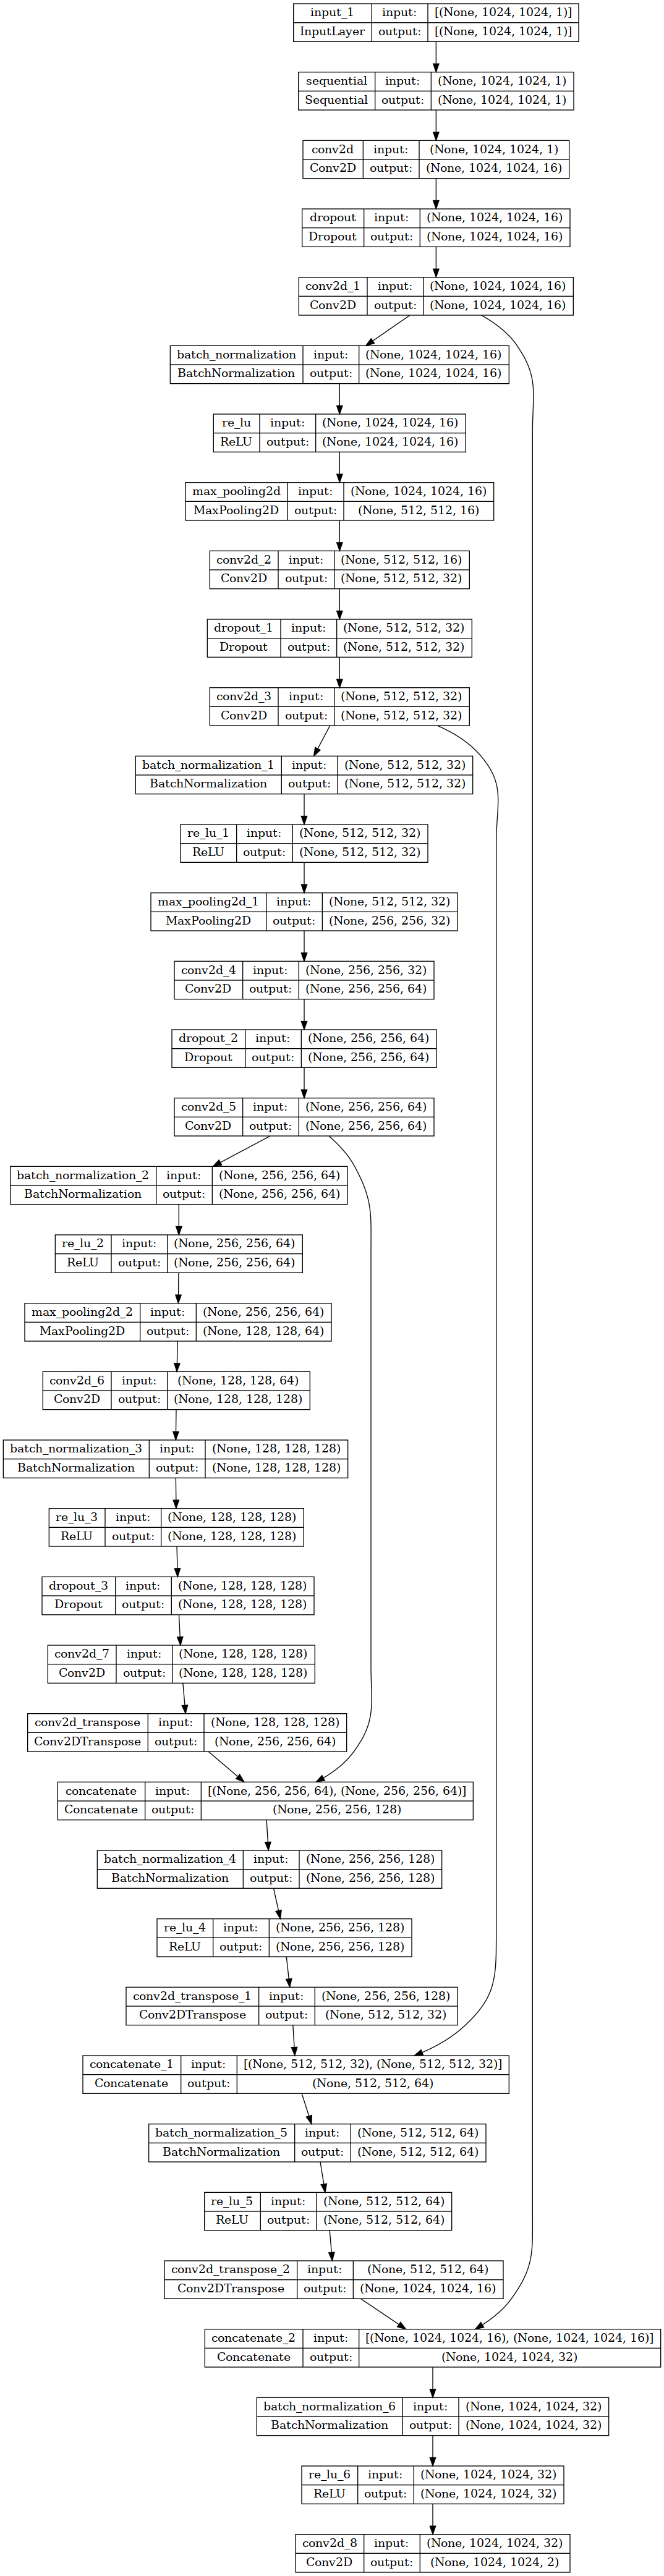

In [8]:
# Visualize model with all layers and shapes
tf.keras.utils.plot_model(model, "model.png", show_shapes=True)

In [7]:
     # Early Stopping sets a epoch patience value to stop training if the monitored metric stops improving
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='9/7_augment_epoch20_0_2_dropout_3layer')]
# Fit the model with the training and/or validation data
# run for fewer epochs to prevent overfitting
model.fit(train_gen, validation_data=val_gen, batch_size=1, epochs=20, callbacks=callbacks)

Epoch 1/20
4/4 [==============================] - 8s 1s/step - loss: 1.1002 - sparse_categorical_crossentropy: 1.1002 - val_loss: 1.0897 - val_sparse_categorical_crossentropy: 1.0897
Epoch 2/20
4/4 [==============================] - 5s 1s/step - loss: 0.9582 - sparse_categorical_crossentropy: 0.9582 - val_loss: 1.0715 - val_sparse_categorical_crossentropy: 1.0715
Epoch 3/20
4/4 [==============================] - 6s 1s/step - loss: 0.8906 - sparse_categorical_crossentropy: 0.8906 - val_loss: 1.0531 - val_sparse_categorical_crossentropy: 1.0531
Epoch 4/20
4/4 [==============================] - 6s 1s/step - loss: 0.8382 - sparse_categorical_crossentropy: 0.8382 - val_loss: 1.0360 - val_sparse_categorical_crossentropy: 1.0360
Epoch 5/20
4/4 [==============================] - 6s 1s/step - loss: 0.8132 - sparse_categorical_crossentropy: 0.8132 - val_loss: 1.0188 - val_sparse_categorical_crossentropy: 1.0188
Epoch 6/20
4/4 [==============================] - 5s 1s/step - loss: 0.7959 - sparse_

In [10]:
# Magic command with tensorboard log directory
%tensorboard --logdir binaryclass_augment_epoch20_0_2_dropout_3layer

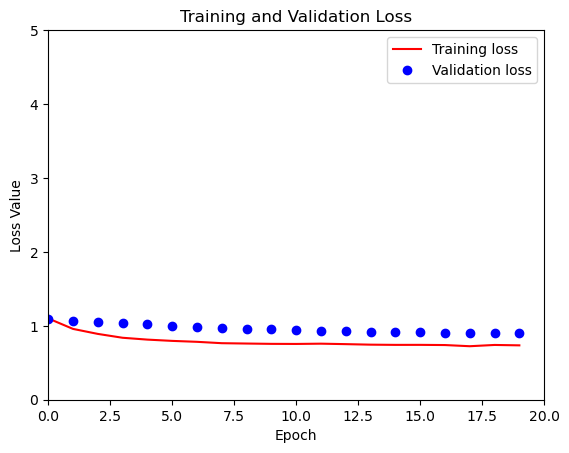

In [9]:
## Training and Validation Loss (L-curve)
import matplotlib.pyplot as plt
# produces L-curve 
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.xlim([0, 20])
plt.ylim([0, 5])
plt.legend()
plt.show()
#plt.savefig("training_validation_loss_binaryclass_augment_epoch20_0_2_dropout_3layer.png")

In [11]:
## Training and Validation Accuracy L-curve
acc = model.history.history['sparse_categorical_accuracy']
val_acc = model.history.history['val_sparse_categorical_accuracy']
# produces L-curve (monitor elbow of the L)
plt.figure()
plt.plot( acc, 'r', label='Training Accuracy')
plt.plot( val_acc, 'bo', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc Value')
plt.xlim([0, 20])
plt.ylim([0, 1])
plt.legend()
plt.show()
#plt.savefig("training_validation_acc_binaryclass_augment_epoch20_0_2_dropout_3layer.png")

KeyError: 'sparse_categorical_accuracy'

4/4 [==============================] - 1s 127ms/step


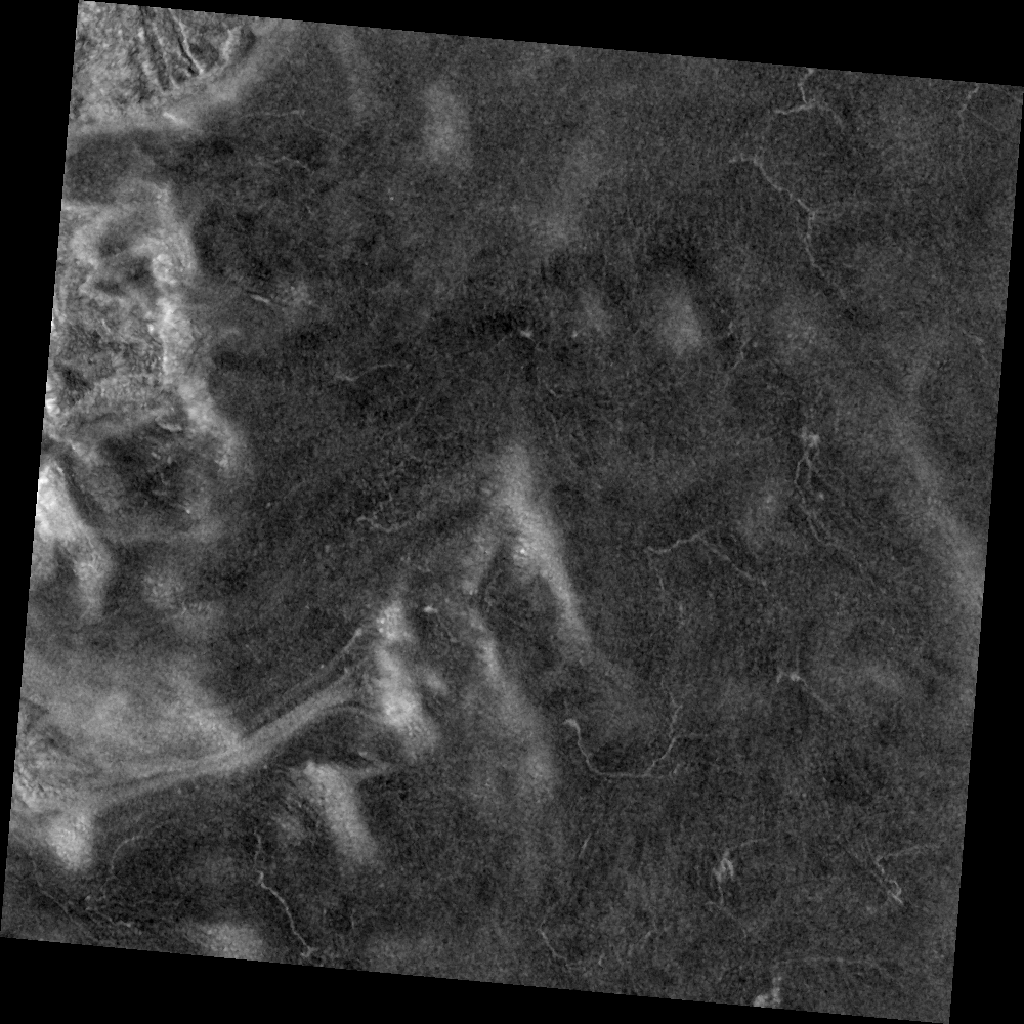

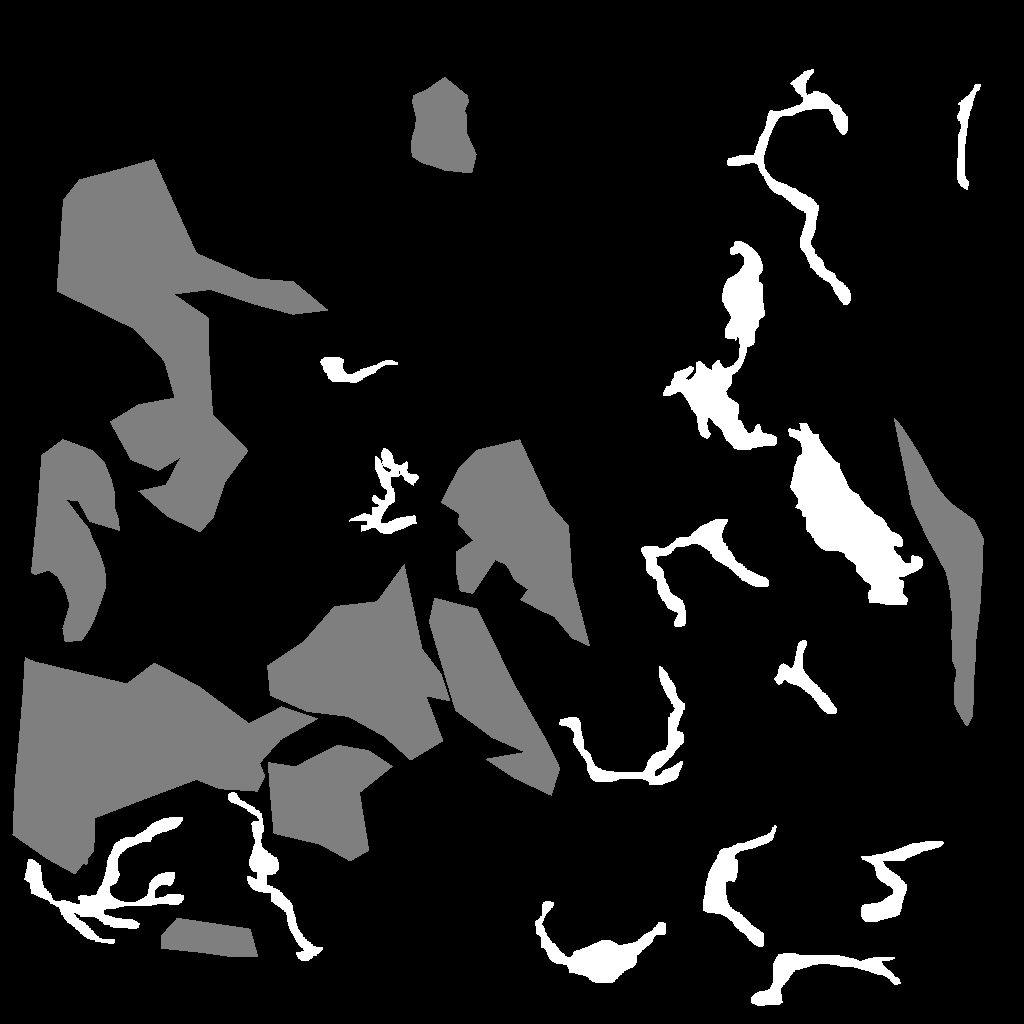

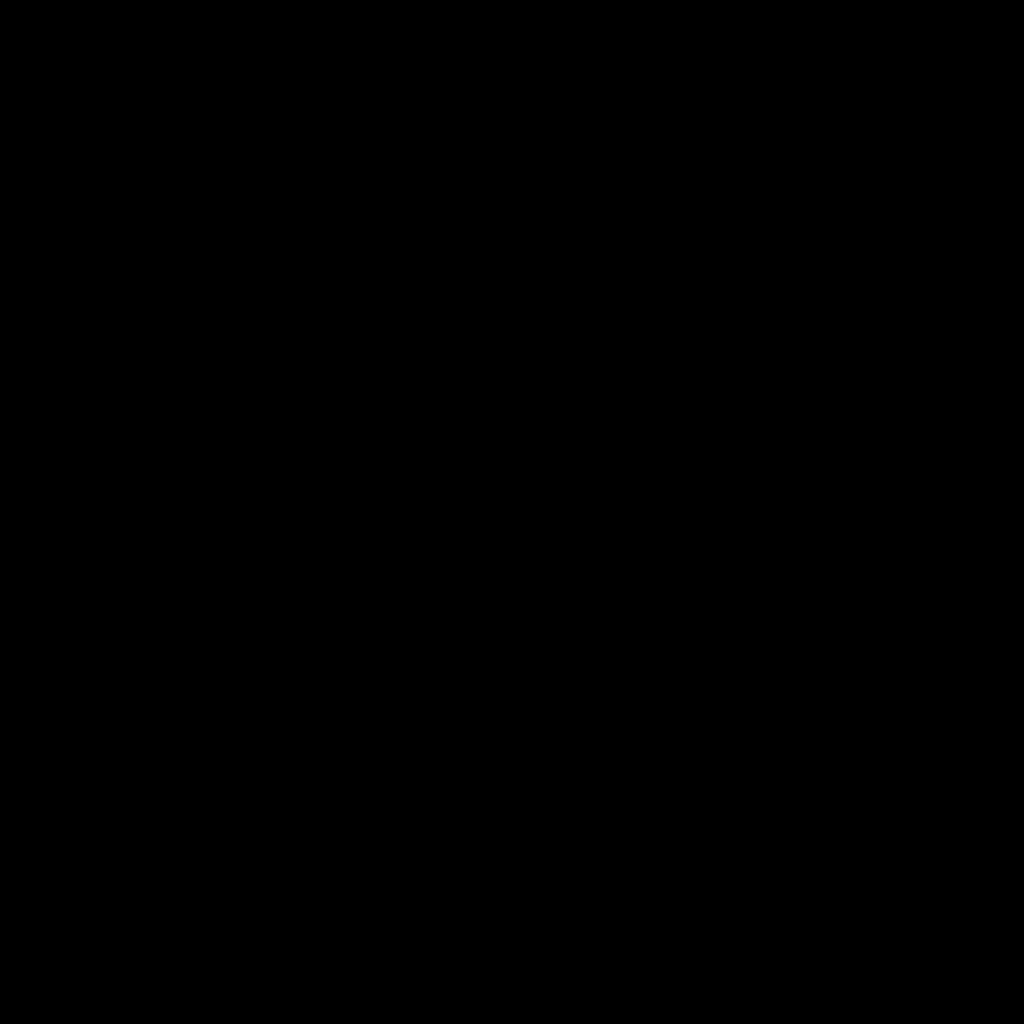

In [16]:
# Generate predictions for all images in the training set

# model.predict can be used for any image (label not required)

train_preds = model.predict(train_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(train_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for image #1
i = 0

# Display input image
display(Image(filename=train_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(train_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.
# save predictions to a folder
# make false-color color map on the prediction 

## To Be Continued ...